# Bayesian Machine Learning

When the data consists of binary Bernoulli random variables with a certain success probability for a positive outcome, the number of successes in repeated trials follows a Binomial distribution. The conjugate prior is the Beta distribution with support over the interval [0, 1] and two shape parameters to model arbitrary prior distributions over the success probability. Hence, the posterior distribution is also a Beta distribution that we can derive by directly updating the parameters.

<h2> Setup and Loading Packages</h2>

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib.ticker import FuncFormatter
import pandas_datareader as pdr


<h2 style="color:Green;">PART 1: Viewing Stock Movements With Bayesian Updates</h2>

<h3> Specifying Stock Details</h3>

In [2]:
SYMBOL = 'INTC' # Stock Ticker symbol
START_DATE = '2016-04-01' # Stock data start date 
END_DATE = '2022-04-01' # Stock data end date 

<h3> Formatting Helper Function </h3> <h3 style="color:Red;"> (DO NOT CHANGE CODE)</h3>

In [3]:
def format_plot(axes, i, p, y, trials, success, true_p, tmle, tmap=None):
    fmt = FuncFormatter(lambda x, _: f'{x:.0%}')
    if i >= 6:
        axes[i].set_xlabel("$p$, Success Probability")
        axes[i].xaxis.set_major_formatter(fmt)
    else:
        axes[i].axes.get_xaxis().set_visible(False)
    if i % 3 == 0:
        axes[i].set_ylabel("Posterior Probability")
    axes[i].set_yticks([])

    axes[i].plot(p, y, lw=1, c='k')
    axes[i].fill_between(p, y, color='darkblue', alpha=0.4)
    axes[i].vlines(true_p, 0, max(10, np.max(y)), color='k', linestyle='--', lw=1)
    axes[i].set_title(f'Trials: {trials:,d} - Success: {success:,d}')
    if i > 0:
        smle = r"$\theta_{{\mathrm{{MLE}}}}$ = {:.2%}".format(tmle)
        axes[i].text(x=.02, y=.85, s=smle, transform=axes[i].transAxes)
        smap = r"$\theta_{{\mathrm{{MAP}}}}$ = {:.2%}".format(tmap)
        axes[i].text(x=.02, y=.75, s=smap, transform=axes[i].transAxes)    
    return axes[i]

<h3> Simulating Stock Price Movements</h3>

 We will pass the stock ticker, start date, and end date variables that we specified above into the `get_data_yahoo` function from the pandas_datareader package. This will load the stock price data from Yahoo Finance into the notebook. Notice that we are using the adjusted close price , which takes into the account dividends and stock splits.

In [4]:
stockPx = pdr.get_data_yahoo(SYMBOL, START_DATE, END_DATE)['Adj Close'] # storing adjusted stock prices into a variable 

We will collect samples of different sizes of binarized daily stock returns where the positive outcome is a price increase - indicated by 1 and the negative is a price decrease - indicated by 0. We do this with the following code.

In [5]:
stockPx01 = (stockPx.pct_change().dropna() > 0).astype(int)
stockPx01.head()

Date
2016-04-04    0
2016-04-05    0
2016-04-06    1
2016-04-07    0
2016-04-08    1
Name: Adj Close, dtype: int32

The actual probability of a positive move is 52.25% from 2016-04-01 to 2022-04-01

In [6]:
round(stockPx01.mean()*100,2)

52.25

Starting from an uninformative prior, uniform distribution, that allocates equal probability to each possible success probability in the interval [0, 1], we compute the posterior for different evidence samples and use this to update the prior sequentially. 

The update is formed by simply adding the observed numbers of success and failure to the parameters of the prior distribution to obtain the posterior.

The resulting posterior distributions are plotted below. They illustrate the evolution from a  uniform prior that views all success probabilities as equally likely to an increasingly peaked distribution. This is because as each trading day passes, analysts have more information about the direction of the market, which shows roughly a 50-50 chance that the stock goes up or down as the sample grows large. 

The plots also show the small differences between MLE and MAP estimates, where the later tends to be pulled slightly towards the expected value of the uniform prior.

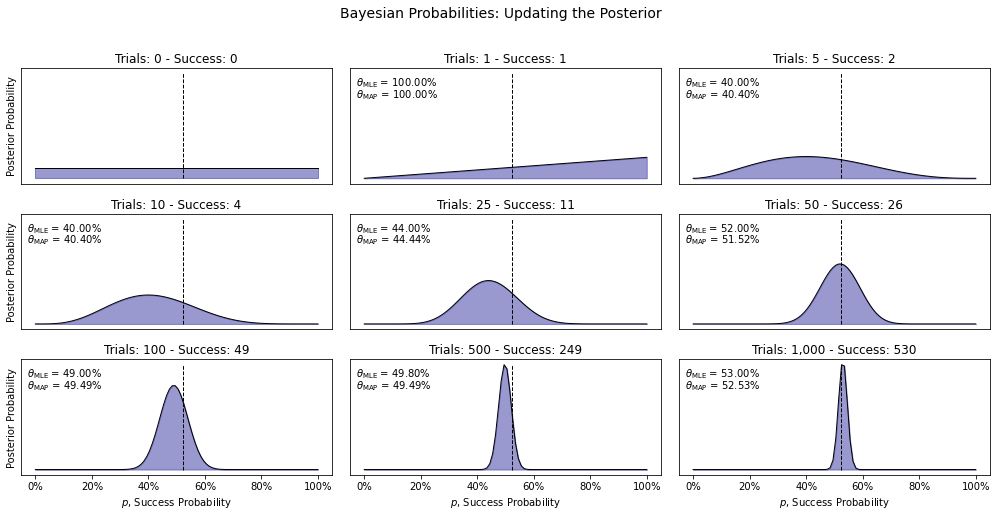

In [7]:
n_days = [0, 1, 5, 10, 25, 50, 100, 500, 1000]
# random sample of 1000 trading days
outcomes = stockPx01.sample(n_days[-1])

# initial 1000 trading days
# outcomes = stockPx01.iloc[:n_days[-1]]

p = np.linspace(0, 1, 100)

# uniform (uninformative) prior distribution
a = b = 1

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 7), sharex=True)
axes = axes.flatten()
for i, days in enumerate(n_days):
    successes = outcomes.iloc[:days]
    theta_mle = successes.mean()
    up = successes.sum()
    down = days - up
    update = stats.beta.pdf(p, a + up , b + down)
    theta_map = pd.Series(update, index=p).idxmax()
    axes[i] = format_plot(axes, i, p, update, trials=days, success=up, 
                          true_p=stockPx01.mean(), tmle=theta_mle, tmap=theta_map)

title = 'Bayesian Probabilities: Updating the Posterior'
fig.suptitle(title,  y=1.02, fontsize=14)
fig.tight_layout()

Text(0, 0.5, 'Probability Density')

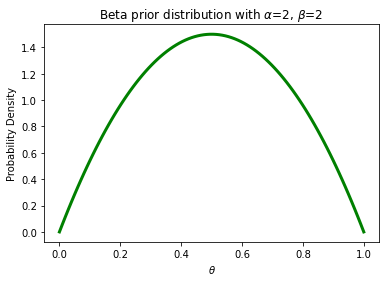

In [34]:
x = np.linspace(0,1, 100)
plt.plot(x, stats.beta.pdf(x, a, b),'g-', lw=3, label='beta pdf')
plt.title('Beta prior distribution with $\\alpha$=2, $\\beta$=2')
plt.xlabel('$\\theta$')
plt.ylabel('Probability Density')